In [33]:
from IPython import get_ipython
get_ipython().magic('reset -sf')


In [34]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
import glob
import re
import os

In [35]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [36]:
import pandas as pd
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, ClassifierMixin
from scipy.optimize import minimize, LinearConstraint, NonlinearConstraint
import pickle
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
import seaborn as sns

In [37]:
## 划分测试集和训练集
train_ratio = 0.8 # 训练集比例

data = pd.read_csv('seeds_dataset.txt', header=None, delim_whitespace=True) # delim_whitespace=True表示分割符为空白字符
data.info
Data = data.iloc[:, :-1].values
labels = data.iloc[:, -1].values

# 划分
X_train, X_test, Y_train, Y_test = train_test_split(Data, labels, train_size=train_ratio, stratify=labels) 

""" labels = pd.Categorical(Y)
X_train, X_test, Y_train, Y_test = train_test_split(features, labels, test_size = 0.2, 
                                            stratify = labels, random_state = 42) """

# 使用StandardScaler类归一化
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [38]:
X_train_scaled = torch.from_numpy(X_train_scaled).float().to(device)
Y_train = torch.from_numpy(Y_train).long().to(device)
X_test_scaled = torch.from_numpy(X_test_scaled).float().to(device)
Y_test = torch.from_numpy(Y_test).long().to(device)


In [39]:
## 定义超圆盘分类器类
class NHCmodel(BaseEstimator, ClassifierMixin):
    def __init__(self, sigma=0) -> None:
        super().__init__()
        self.sigma = sigma
        self.classes = 0
        self.s_r = {}
        self.classifiers = {}
        self.predictData = None
        self.accuracy = 0

    def gaussian_kernel(self, x, y):
        return torch.exp(-torch.norm(x-y, p=2, dim=1)**2 / (2 * (self.sigma ** 2)))
    
    def Objective_Function1(self, beta, X):
        """返回超圆盘的对偶问题的目标函数，在某一拉格朗日系数下的值
        Args:
            beta (Tensor): 为该输入样本集合下的拉格朗日系数
            X (Tensor): X为输入样本矩阵, 行为样本个数, 列为样本特征
        """
        beta = beta.reshape(-1, 1)
        # print(X)
        return torch.sum(beta*torch.sum(X*X, dim=1).reshape(-1, 1))-torch.sum((beta*X)@(beta*X).T)

    
    def Objective_Function2(self, alpha, X_plus, X_minus):
        M_plus  = X_plus.size()[0]
        alpha_plus = alpha[:M_plus]
        alpha_minus = alpha[M_plus:]
        M_minus = alpha_minus.size()[0]
        result = 0
        for i in range(M_plus):
            result = result + torch.sum(alpha_plus[i]*alpha_plus*self.gaussian_kernel(X_plus[i, :], X_plus))
            - 2*torch.sum(alpha_plus[i]*alpha_minus*self.gaussian_kernel(X_plus[i, :], X_minus))
        for i in range(M_minus):
            result = result + torch.sum(alpha_minus[i]*alpha_minus*self.gaussian_kernel(X_minus[i, :], X_minus))
        return result

    
    def nonlcon(self, alpha, beta_plus, beta_minus, X_plus, X_minus, r_plus, r_minus):
        M_plus  = X_plus.size()[0]
        alpha_plus = alpha[:M_plus]
        alpha_minus = alpha[M_plus:]
        M_minus = alpha_minus.size()[0]
        
        c = torch.zeros((2, 1))
        for i in range(M_plus):
            c[0] = c[0] + torch.sum(alpha_plus[i]*alpha_plus*self.gaussian_kernel(X_plus[i, :],X_plus))
            - torch.sum(alpha_plus[i]*beta_plus*self.gaussian_kernel(X_plus[i, :], X_plus))
            + torch.sum(beta_plus[i]*beta_plus*self.gaussian_kernel(X_plus[i, :], X_plus))
        c[0] -= r_plus**2
        for i in range(M_minus):
            c[0] = c[0] + torch.sum(alpha_minus[i]*alpha_minus*self.gaussian_kernel(X_minus[i, :],X_minus))
            - torch.sum(alpha_minus[i]*beta_minus*self.gaussian_kernel(X_minus[i, :], X_minus))
            + torch.sum(beta_minus[i]*beta_minus*self.gaussian_kernel(X_minus[i, :], X_minus))
        c[1] -= r_minus**2
        return c.flatten()


    def fit(self, X, y):
        # 拟合函数
        classes = torch.unique(y)
        Num = classes.size()[0]
        beta = torch.zeros((Num, y.size()[0]))
        s_and_r = torch.ones((Num, X.size()[1]+1))
        # 分类求解超圆盘对偶问题拉格朗日系数，以求解s和r
        for i in classes:
            Xx = X[y==i, :]
            M = Xx.size()[0]
            # 设定拉格朗日系数beta初值,一个样本一个beta
            beta_init = torch.ones((M)) / M # 一维数组，但是在优化函数里面需要reshape乘二维数组才能运算
            # 设线性等式约束
            Aeq1 = torch.ones((1, M))
            beq1 = torch.tensor([1])
            linearConstraint1 = LinearConstraint(Aeq1, beq1, beq1)
            # 设定beta下界
            bounds = [(1e-6, None) for _ in range(M)] 
            # 求解beta
            result1 = minimize(self.Objective_Function1, beta_init, 
                            args=(Xx,), method='SLSQP', bounds=bounds, constraints=linearConstraint1,
                            )
            beta[i-1, :M] = result1.x
            
            s = torch.sum(result1.x.reshape(-1, 1)*Xx, 0)
            r = torch.max(torch.norm(Xx-s, p=2,dim=1))
            s_and_r[i-1, :] = torch.cat([s, r.unsqueeze(0)])
            
            self.s_r = {'s': s,
                        'r': r}
        # 求解多个分类器的参数，即分类超平面参数，OVO策略
        Num_classifier = int(Num*(Num-1)/2)
        b_classifier = torch.zeros((Num_classifier, 1))
        iter = 0
        for i in range(Num-1):
            for j in range(i+1, Num):
                iter += 1
                # 获取基本信息
                X_plus = X[y==i+1, :]
                X_minus = X[y==j+1, :]
                M_plus = X_plus.size()[0]
                M_minus = X_minus.size()[0]
                # 设定超平面参数初值，都为列
                alpha_plus = torch.ones((M_plus)) / M_plus
                alpha_minus = torch.ones((M_minus)) / M_minus
                alpha_init = torch.cat((alpha_plus, alpha_minus), dim=0)
                # 设定线性等式约束
                Aeq2 = torch.zeros((2, M_plus+M_minus))
                Aeq2[0,:M_plus] = 1;
                Aeq2[1, M_plus:] = 1
                beq2 = np.array([1, 1])
                linearConstraint2 = LinearConstraint(Aeq2, beq2, beq2)
                # 设定不等式约束
                r_plus = s_and_r[i, -1]
                r_minus = s_and_r[j, -1]
                beta_plus = beta[i, :M_plus]
                beta_minus = beta[j, :M_minus]
                lb = -np.inf
                ub = np.tensor([0, 0])
                # NonlinearConstraint(lambda x: NHCmodel.nonlcon(x, beta_plus, beta_minus, X_plus, X_minus, r_plus_minus), lb, ub)
                # 这个和@(beta)Objective_Function1(beta, X),@(beta) 表示输入要优化的值为beta，X不动，异曲同工
                nonlinearConstraint =  NonlinearConstraint(lambda x: NHCmodel.nonlcon(self, x, beta_plus, beta_minus, X_plus, X_minus, r_plus, r_minus), lb, ub)
                constraints = [linearConstraint2, nonlinearConstraint]
                # 求解alpha
                result2 = minimize(self.Objective_Function2, alpha_init, args=(X_plus, X_minus,),
                                   method='SLSQP', constraints=constraints)
                alpha = result2.x
                alpha_plus = alpha[:M_plus]
                alpha_minus = alpha[M_plus:]
                # 求解b
                for k in range(M_plus):
                    b_classifier[iter-1] += torch.sum(alpha_plus[k]*alpha_plus*self.gaussian_kernel(X_plus[k, :], X_plus))
                for k in range(M_minus):
                    b_classifier[iter-1] -= torch.sum(alpha_minus[k]*alpha_minus*self.gaussian_kernel(X_minus[k, :], X_minus))
                b_classifier[iter-1] = -1/2*b_classifier[iter-1]
                b = b_classifier[iter-1]
                self.classes = Num
                self.classifiers[(i+1, j+1)] = {'X+': X_plus,
                                                'X-': X_minus,
                                                'alpha+': alpha_plus,
                                                'alpha-': alpha_minus,
                                                'b': b}    
        # 保存分类器参数字典
        with open('classifiers.pkl', 'wb') as f:
            pickle.dump(self.classifiers, f)                                  
        return 0  
                

    def predict(self,X):
        fx = torch.zeros((X.size()[0], self.classes))
        indexclasses = 0
        fxij = torch.zeros((X.size()[0], self.classes))
        for (i, j), classifier in self.classifiers.items():
            indexclasses += 1
            X_pl = classifier['X+']
            X_mi = classifier['X-']
            alpha_pl = classifier['alpha+']
            alpha_mi = classifier['alpha-']
            bb = classifier['b']
            
            M_plus = X_pl.size()[0]
            M_minus = X_mi.size()[0]
            
            for g in range(M_plus):
                fx[:, indexclasses-1] = fx[:, indexclasses-1] + alpha_pl[g]*self.gaussian_kernel(X_pl[g, :], X).reshape(-1)
            for g in range(M_minus):
                fx[:, indexclasses-1] = fx[:, indexclasses-1] - alpha_mi[g]*self.gaussian_kernel(X_mi[g, :], X).reshape(-1)
            
            fx[:, indexclasses-1] = torch.sign(fx[:, indexclasses-1] + bb)
            fxij[:, indexclasses-1] = fx[:, indexclasses-1] 
            fx[:, indexclasses-1][fx[:, indexclasses-1]==1] = i
            fx[:, indexclasses-1][fx[:, indexclasses-1]==-1] = j
            fx[:, indexclasses-1][fx[:, indexclasses-1]==0] = 0

        y_pred = torch.argmax(torch.bincount(fx.type(torch.int64)), dim=1) # axis表示假如你是n×m维度，axis=0，表示在n方向上，axis=1，表示在m方向上
        y_pred = y_pred.reshape(-1, 1)
        self.predictData = torch.cat((X, y_pred, fxij, fx), dim=1)
        return y_pred

    
    def score(self, X, y):
        y_pred = self.predict(X)
        y = y.reshape(-1, 1)
        accuracy = torch.sum(y_pred==y).item() / y.numel()
        self.accuracy = accuracy
        return accuracy

              

手搓数据集划分

classes = labels.unique()
trainData = pd.DataFrame(data=None, index=None)
testData = pd.DataFrame(data=None, index=None)

for i in classes:
    classData = data.loc[labels==i, :]
    numTrain = round(train_ratio*classData.shape[0]) # 训练集样本数
    indices = np.random.permutation(classData.shape[0])
    
    trainData = pd.concat([trainData, classData.iloc[indices[0:numTrain], :]])
    testData = pd.concat([testData, classData.iloc[indices[numTrain:], :]])

trainData.info
testData.info                                            
trainData.to_csv('trainData.csv', header=0, index=0, sep='\t')
testData.to_csv('testData.csv', header=0, index=0, sep='\t')


In [40]:
"""# 网格搜索最佳sigma
param_grid = {'sigma': (2 ** np.arange(-5, 5.5, 0.5)).tolist()}

testmodel = NHCmodel()
grid_search = GridSearchCV(testmodel, param_grid=param_grid, cv=5)

grid_search.fit(Data, labels)
sigma = grid_search.best_params_
score = grid_search.best_score_
print(sigma, score)
"""

sigma = 0.25

In [41]:
## 训练
model = NHCmodel(sigma) # 必须有输入值！！
model.fit(X_train_scaled, Y_train)

TypeError: unsupported operand type(s) for *: 'numpy.ndarray' and 'Tensor'

In [ ]:
# 测试
Y_pred = model.predict(X_test_scaled)

F1 Score = 0.8333333333333334
Accuracy = 83.333 %


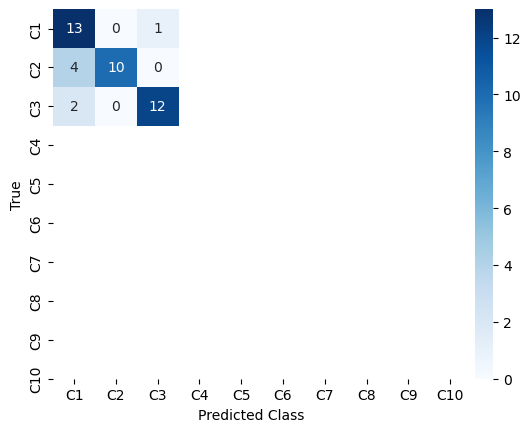

In [ ]:
Accuracy = accuracy_score(Y_test, Y_pred)
# accuracy = model.score(X_test_scaled, Y_test)
test_confu_matrix = confusion_matrix(Y_test, Y_pred)
fault_type = ['C1','C2','C3','C4','C5','C6','C7','C8','C9','C10']
sns.heatmap(test_confu_matrix, annot= True,fmt = "d",
xticklabels=fault_type, yticklabels=fault_type, cmap = "Blues")
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.ylabel('True')
F1_score = f1_score(Y_test, Y_pred,average='micro')

print("F1 Score =", F1_score)
print("Accuracy = %.3f" % (Accuracy*100), "%")
